<center>
<h1> Credit Risk Analytics
</center>

###### Definition of Target and Outcome Window:
One of the leading banks would like to predict bad customer while customer applying for loan. This model also called as PD Models (Probability of Default)


###### Data Pre-Processing - 
    - Missing Values Treatment - Numerical (Mean/Median imputation) and Categorical (Separate Missing Category or Merging)
    - Univariate Analysis - Outlier and Frequency Analysis
###### Data Exploratory Analysis
    - Bivariate Analysis - Numeric(TTest) and Categorical(Chisquare)
    - Bivariate Analysis - Visualization
    - Variable Transformation - P-Value based selection
    - Variable Transformation - Bucketing / Binning for numerical variables and Dummy for Categorical Variables
    - Variable Reduction - IV / Somers'D
    - Variable Reduction - Multicollinearity
###### Model Build and Model Diagnostics
    - Train and Test split
    - Significance of each Variable
    - Gini and ROC / Concordance analysis - Rank Ordering
    - Classification Table Analysis - Accuracy
    - H-L Test for Accuracy by segments (Not done in this notebook)
###### Model Validation
    - OOS validation - p-value and sign testing for the model coefficients
    - Diagnostics check to remain similar to Training Model build
    - BootStrapping, if necessary
###### Model Interpretation for its properties
    - Inferencing for finding the most important contributors
    - Prediction of risk and proactive prevention by targeting segments of the population

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.formula.api as sm
import scipy.stats as stats
import pandas_profiling   #need to install using anaconda prompt (pip install pandas_profiling)

%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 7.5
plt.rcParams['axes.grid'] = True
plt.gray()

from matplotlib.backends.backend_pdf import PdfPages

from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

C:\Users\USER\Anaconda3\lib\site-packages\pandas_profiling\plot.py:15: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "C:\Users\USER\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\USER\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\USER\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\USER\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 486, in start
    self.io_loop.start()
  File "C:\Users\USER\Anac

<Figure size 720x540 with 0 Axes>

In [2]:
# Load the data
bankloans = pd.read_csv( 'bankloans.csv' )

In [3]:
bankloans.columns

Index(['age', 'ed', 'employ', 'address', 'income', 'debtinc', 'creddebt',
       'othdebt', 'default'],
      dtype='object')

In [4]:
bankloans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 9 columns):
age         850 non-null int64
ed          850 non-null int64
employ      850 non-null int64
address     850 non-null int64
income      850 non-null int64
debtinc     850 non-null float64
creddebt    850 non-null float64
othdebt     850 non-null float64
default     700 non-null float64
dtypes: float64(4), int64(5)
memory usage: 59.8 KB


In [6]:
numeric_var_names=[key for key in dict(bankloans.dtypes) if dict(bankloans.dtypes)[key] in ['float64', 'int64', 'float32', 'int32']]
cat_var_names=[key for key in dict(bankloans.dtypes) if dict(bankloans.dtypes)[key] in ['object']]
print(numeric_var_names)
print(cat_var_names)

['age', 'ed', 'employ', 'address', 'income', 'debtinc', 'creddebt', 'othdebt', 'default']
[]


In [7]:
bankloans_num=bankloans[numeric_var_names]
bankloans_num.head(5)

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
0,41,3,17,12,176,9.3,11.359392,5.008608,1.0
1,27,1,10,6,31,17.3,1.362202,4.000798,0.0
2,40,1,15,14,55,5.5,0.856075,2.168925,0.0
3,41,1,15,14,120,2.9,2.658720,0.821280,0.0
4,24,2,2,0,28,17.3,1.787436,3.056564,1.0


In [8]:
bankloans_cat = bankloans[cat_var_names]
bankloans_cat.head(5)

""
0
1
2
3
4


In [9]:
# Creating Data audit Report
# Use a general function that returns multiple values
def var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  x.std(), x.var(), x.min(), x.dropna().quantile(0.01), x.dropna().quantile(0.05),x.dropna().quantile(0.10),x.dropna().quantile(0.25),x.dropna().quantile(0.50),x.dropna().quantile(0.75), x.dropna().quantile(0.90),x.dropna().quantile(0.95), x.dropna().quantile(0.99),x.max()], 
                  index=['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1' , 'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

num_summary=bankloans_num.apply(lambda x: var_summary(x)).T

In [10]:
num_summary

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
age,850.0,0.0,29775.000000,35.029412,34.000000,8.041432,64.664623,20.000000,21.000000,23.000000,25.000000,29.000000,34.000000,41.000000,47.000000,49.000000,53.000000,56.00000
ed,850.0,0.0,1454.000000,1.710588,1.000000,0.927784,0.860783,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,3.000000,4.000000,4.000000,5.00000
employ,850.0,0.0,7281.000000,8.565882,7.000000,6.777884,45.939706,0.000000,0.000000,0.000000,1.000000,3.000000,7.000000,13.000000,18.000000,21.550000,29.000000,33.00000
address,850.0,0.0,7116.000000,8.371765,7.000000,6.895016,47.541251,0.000000,0.000000,0.000000,1.000000,3.000000,7.000000,12.000000,19.000000,22.550000,26.510000,34.00000
income,850.0,0.0,39674.000000,46.675294,35.000000,38.543054,1485.566998,13.000000,14.490000,17.000000,19.000000,24.000000,35.000000,55.750000,84.000000,115.550000,220.510000,446.00000
debtinc,850.0,0.0,8645.900000,10.171647,8.700000,6.719441,45.150891,0.100000,0.900000,1.900000,2.900000,5.100000,8.700000,13.800000,19.200000,23.510000,31.565000,41.30000
creddebt,850.0,0.0,1340.284021,1.576805,0.885091,2.125840,4.519196,0.011696,0.030349,0.108927,0.178306,0.382176,0.885091,1.898440,3.703304,5.348674,10.285997,20.56131
othdebt,850.0,0.0,2616.970979,3.078789,2.003243,3.398803,11.551864,0.045584,0.162394,0.359900,0.552050,1.045942,2.003243,3.903001,7.111941,9.481105,16.931503,35.19750
default,700.0,150.0,183.000000,0.261429,0.000000,0.439727,0.193360,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.00000


In [11]:
#Detailed profiling using pandas profiling

pandas_profiling.ProfileReport(bankloans)

Number of variables,9
Number of observations,850
Total Missing (%),2.0%
Total size in memory,59.8 KiB
Average record size in memory,72.1 B
Numeric,9
Categorical,0
Boolean,0
Date,0
Text (Unique),0
Rejected,0


In [12]:
bankloans_existing = bankloans_num[bankloans_num.default.isnull()==0]
bankloans_new = bankloans_num[bankloans_num.default.isnull()==1]

In [13]:
pandas_profiling.ProfileReport(bankloans_existing)

Number of variables,9
Number of observations,700
Total Missing (%),0.0%
Total size in memory,54.7 KiB
Average record size in memory,80.0 B
Numeric,8
Categorical,0
Boolean,1
Date,0
Text (Unique),0
Rejected,0


In [14]:
#Handling Outliers - Method2
def outlier_capping(x):
    x = x.clip_upper(x.quantile(0.99))
    x = x.clip_lower(x.quantile(0.01))
    return x

bankloans_existing=bankloans_existing.apply(lambda x: outlier_capping(x))

In [15]:
#Handling missings - Method2
def Missing_imputation(x):
    x = x.fillna(x.mean())
    return x

bankloans_existing=bankloans_existing.apply(lambda x: Missing_imputation(x))

In [16]:
bankloans_existing.corr()

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
age,1.000000,0.016576,0.537417,0.596973,0.521450,0.016926,0.308318,0.348911,-0.138654
ed,0.016576,1.000000,-0.158071,0.055560,0.225395,0.009992,0.103012,0.156523,0.118521
employ,0.537417,-0.158071,1.000000,0.324859,0.665369,-0.035332,0.405959,0.419337,-0.287197
address,0.596973,0.055560,0.324859,1.000000,0.345067,0.014967,0.215397,0.234896,-0.165389
income,0.521450,0.225395,0.665369,0.345067,1.000000,-0.022541,0.553114,0.626787,-0.099553
debtinc,0.016926,0.009992,-0.035332,0.014967,-0.022541,1.000000,0.534602,0.603630,0.388556
creddebt,0.308318,0.103012,0.405959,0.215397,0.553114,0.534602,1.000000,0.639984,0.238179
othdebt,0.348911,0.156523,0.419337,0.234896,0.626787,0.603630,0.639984,1.000000,0.138962
default,-0.138654,0.118521,-0.287197,-0.165389,-0.099553,0.388556,0.238179,0.138962,1.000000


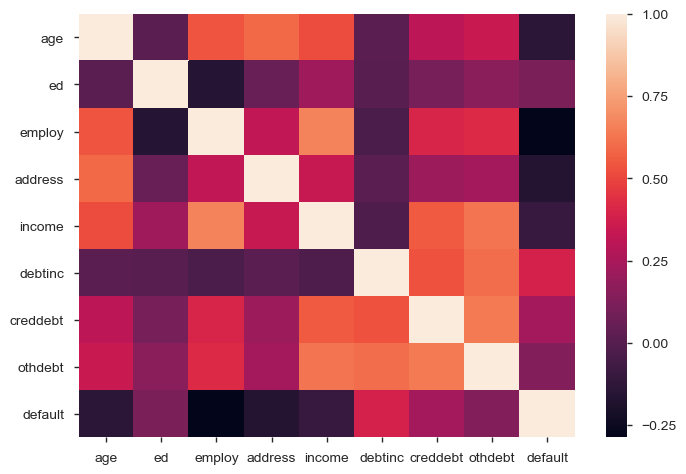

In [17]:
# visualize correlation matrix in Seaborn using a heatmap
sns.heatmap(bankloans_existing.corr())

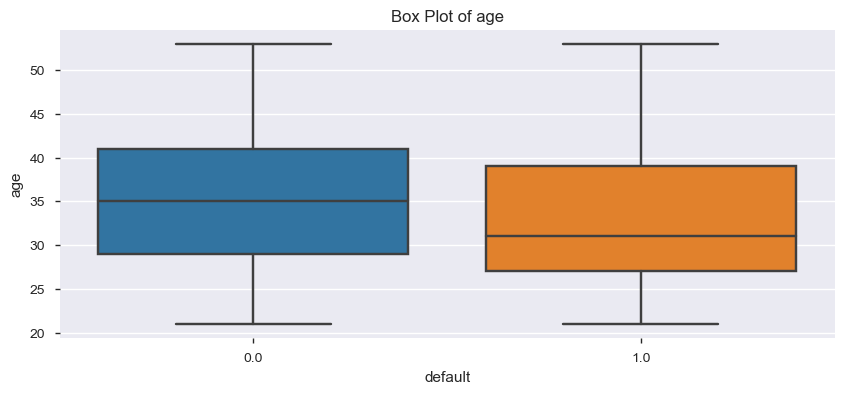

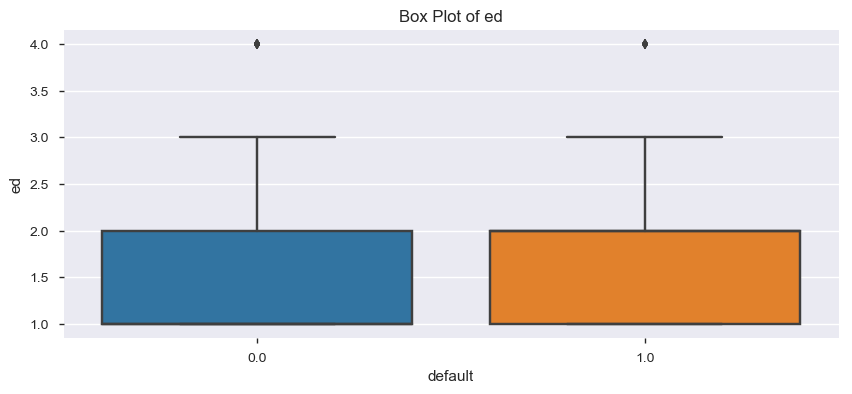

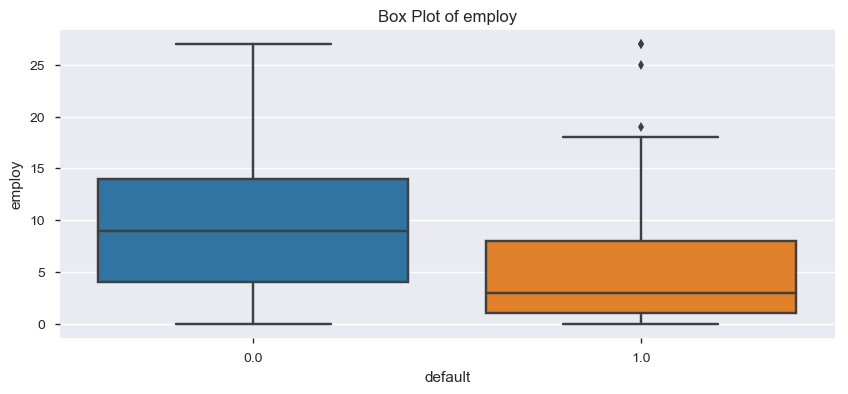

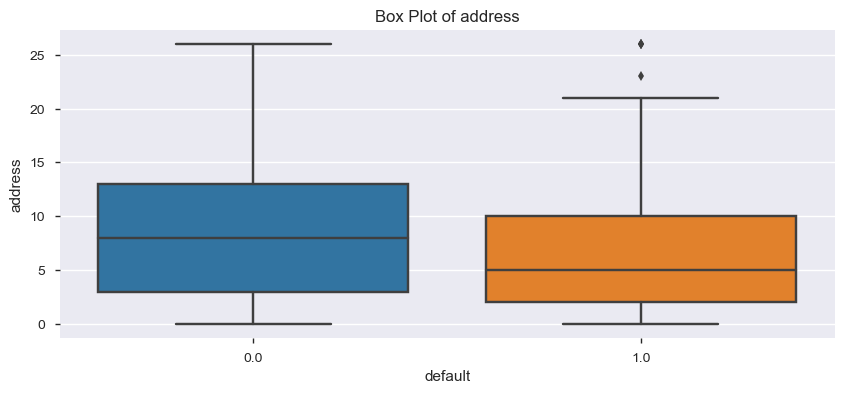

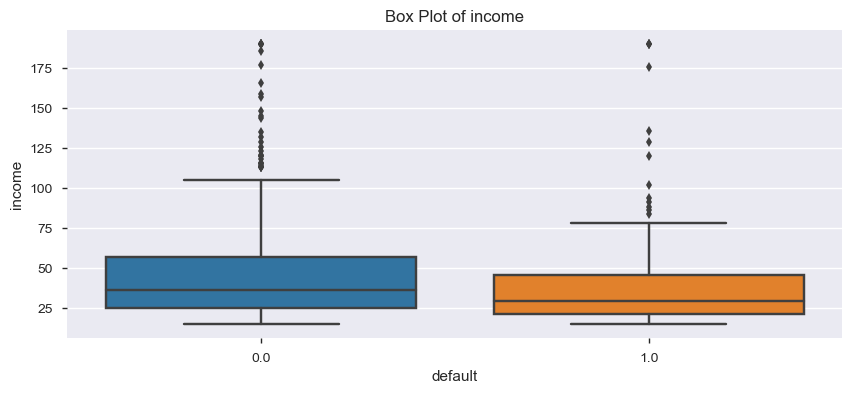

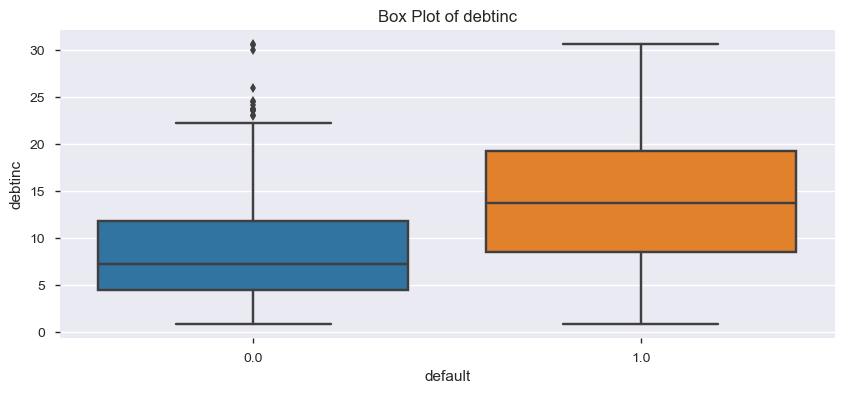

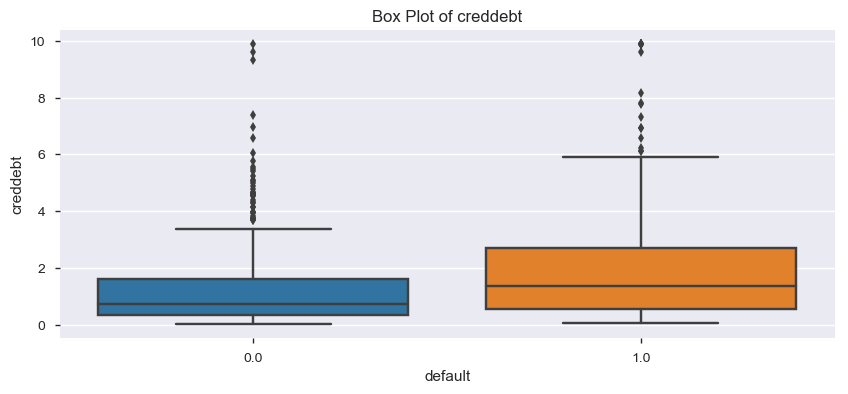

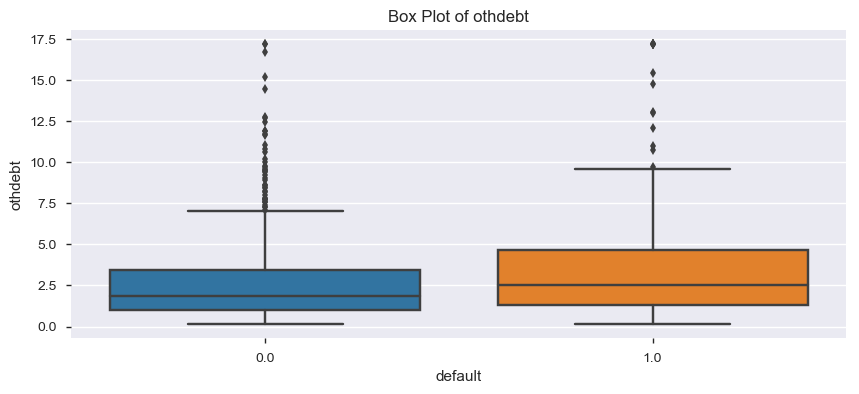

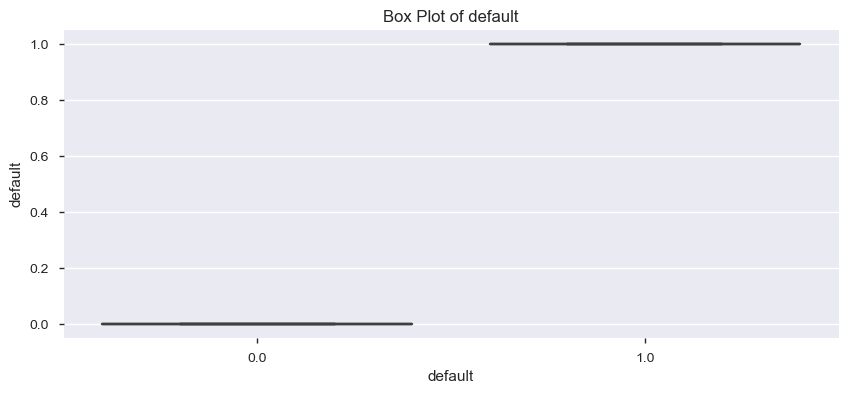

In [20]:
bp = PdfPages('BoxPlots with default Split.pdf')

for num_variable in numeric_var_names:
    fig,axes = plt.subplots(figsize=(10,4))
    sns.boxplot(x='default', y=num_variable, data = bankloans_existing)
    plt.title(str('Box Plot of ') + str(num_variable))
    bp.savefig(fig)
bp.close()

###### 2.1 Data Exploratory Analysis
    - Bivariate Analysis - Numeric(TTest/ANOVA) and Categorical(Chisquare)

In [21]:
## Numerical Variable
tstats_df = pd.DataFrame()
for num_variable in numeric_var_names:
    tstats = stats.ttest_ind(bankloans_existing[bankloans_existing['default']==1][num_variable],bankloans_existing[bankloans_existing['default']==0][num_variable])
    temp = pd.DataFrame([num_variable, tstats[0], tstats[1]]).T
    temp.columns = ['Variable Name', 'T-Statistic', 'P-Value']
    tstats_df = pd.concat([tstats_df, temp], axis=0, ignore_index=True)

print(tstats_df)

  Variable Name T-Statistic      P-Value
0           age    -3.69893  0.000233527
1            ed     3.15351   0.00168236
2        employ    -7.92136  9.27995e-15
3       address    -4.43055  1.09104e-05
4        income    -2.64329   0.00839468
5       debtinc     11.1409  1.20241e-26
6      creddebt     6.47909   1.7428e-10
7       othdebt      3.7073  0.000226095
8       default         inf            0


###### 2.2 Data Exploratory Analysis
    - Visualization of variable importance

###### 2.4 Data Exploratory Analysis
    - Variable Transformation: (i) Bucketing

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


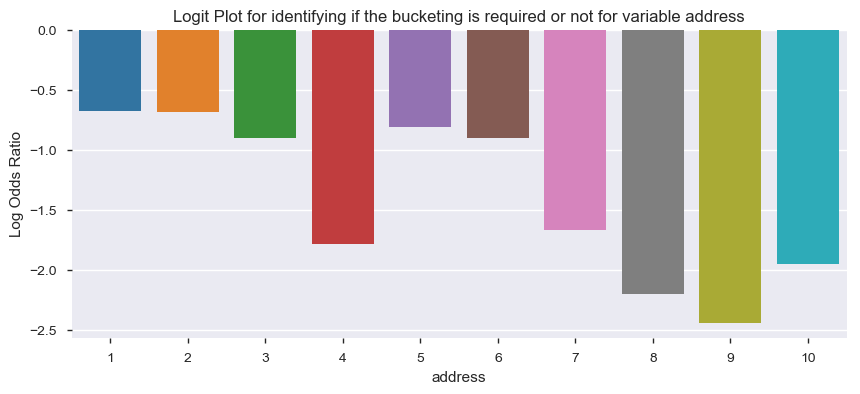

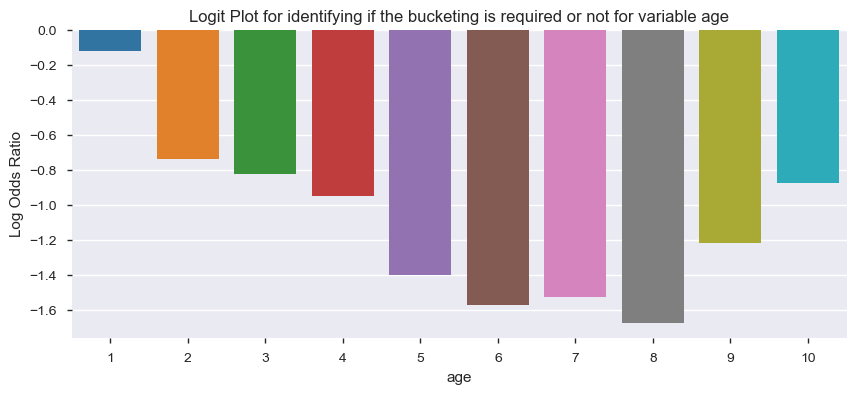

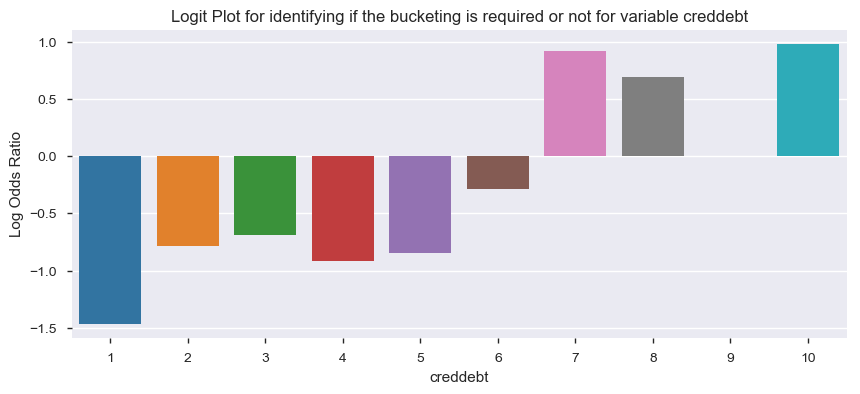

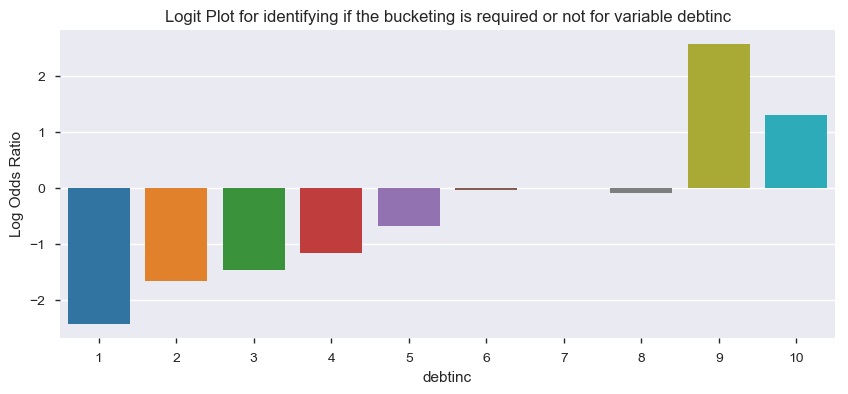

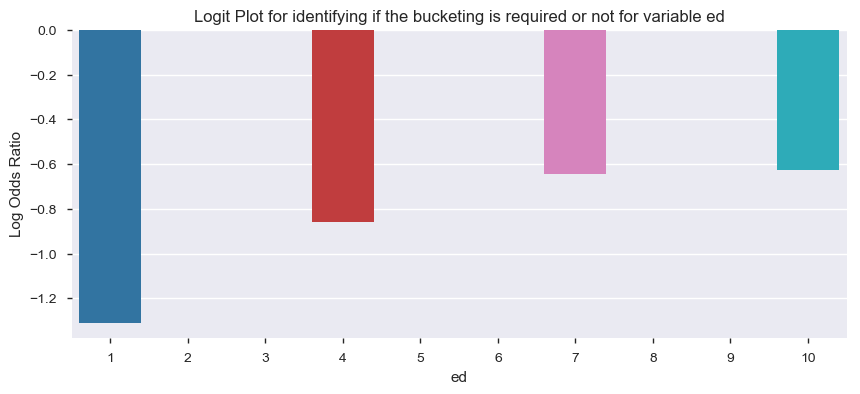

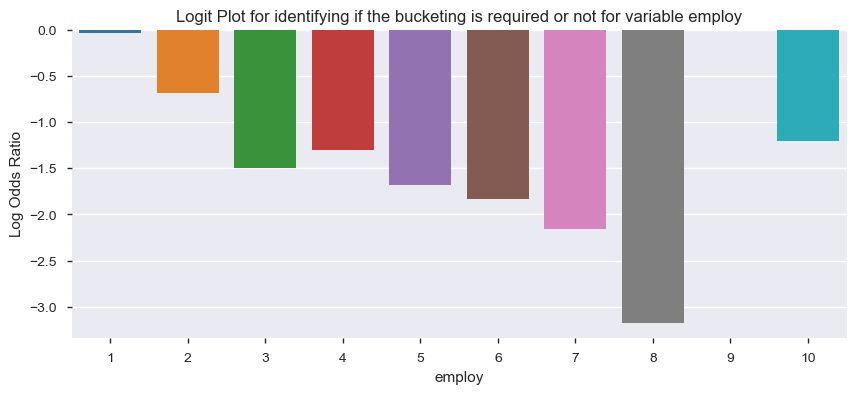

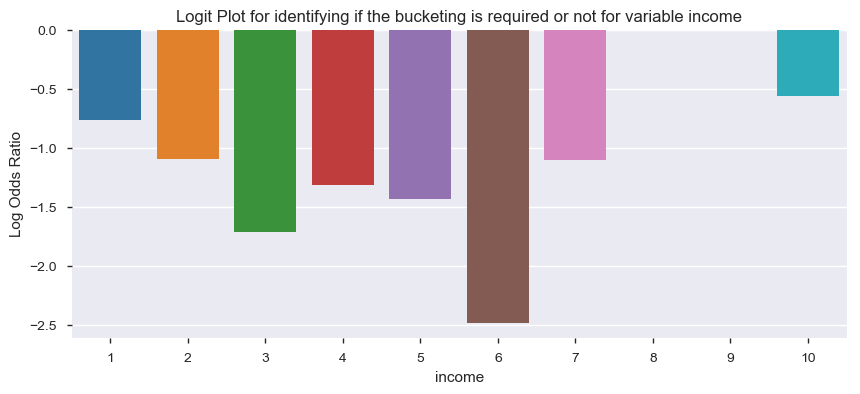

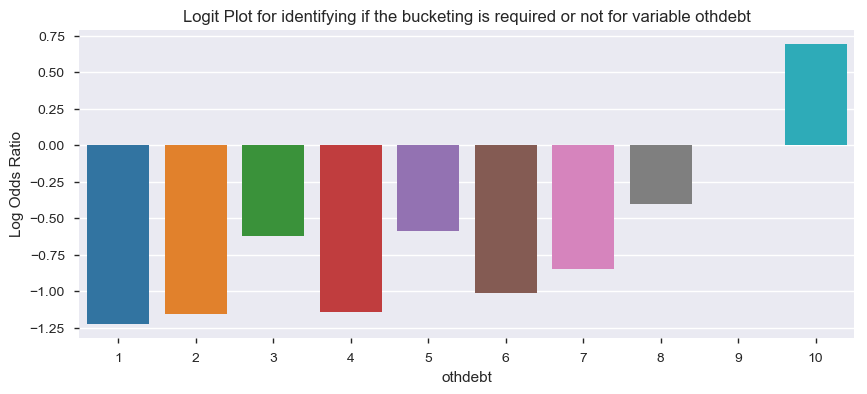

In [23]:
bp = PdfPages('Transformation Plots.pdf')

for num_variable in bankloans_existing.columns.difference(['default']):
    binned = pd.cut(bankloans_existing[num_variable], bins=10, labels=list(range(1,11)))
    binned = binned.dropna()
    ser = bankloans_existing.groupby(binned)['default'].sum() / (bankloans_existing.groupby(binned)['default'].count()-bankloans_existing.groupby(binned)['default'].sum())
    ser = np.log(ser)
    fig,axes = plt.subplots(figsize=(10,4))
    sns.barplot(x=ser.index,y=ser)
    plt.ylabel('Log Odds Ratio')
    plt.title(str('Logit Plot for identifying if the bucketing is required or not for variable ') + str(num_variable))
    bp.savefig(fig)

bp.close()

In [21]:
print('These variables need bucketing - creddebt, othdebt, debtinc, employ, income ')
bankloans_existing.columns

These variables need bucketing - creddebt, othdebt, debtinc, employ, income 


Index([u'default', u'ed', u'age', u'address', u'employ', u'debtinc', u'income',
       u'othdebt', u'creddebt'],
      dtype='object')

In [22]:
bankloans_existing[['creddebt', 'othdebt', 'debtinc', 'employ','income' ]].describe(percentiles=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]).T

,count,mean,std,min,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
creddebt,700.0,1.498843,1.788451,0.030209,0.170020,0.301390,0.440418,0.593059,0.854869,1.183471,1.615023,2.288026,3.621504,9.891428
othdebt,700.0,3.027290,3.115401,0.160936,0.562232,0.900747,1.165766,1.546101,1.987567,2.511054,3.258777,4.577926,7.036180,17.184744
debtinc,700.0,10.222153,6.682160,0.900000,2.900000,4.500000,5.800000,7.000000,8.600000,10.500000,12.900000,15.440000,19.610000,30.701000
employ,700.0,8.358671,6.566008,0.000000,1.000000,2.000000,4.000000,5.600000,7.000000,9.000000,11.000000,14.000000,18.000000,27.010000
income,700.0,44.848714,31.942133,15.000000,19.000000,22.000000,26.000000,29.000000,34.000000,40.400000,49.000000,61.000000,82.000000,190.300000


In [23]:
#bucekting
#bankloans_existing['creddebt_extreme'] = bankloans_existing['creddebt'].apply(lambda x: 0 if 162 < x < 221 else 1)
#bankloans_existing['othdebt_extreme'] = bankloans_existing['othdebt'].apply(lambda x: 0 if 0.6 <= x < 0.84 else 1)
#bankloans_existing['debtinc_extreme'] = bankloans_existing['debtinc'].apply(lambda x: 0 if 0.6 <= x < 0.84 else 1)
#bankloans_existing['debtinc_extreme'].value_counts()

###### 2.5 Data Exploratory Analysis
    - Variable Reduction using Somer's D values

In [24]:

somersd_df = pd.DataFrame()
for num_variable in bankloans_existing.columns.difference(['default']):
    logreg = sm.logit(formula = str('default ~ ')+str(num_variable), data=bankloans_existing)
    result = logreg.fit()
    summ = result.summary2()
    y_score = pd.DataFrame(result.predict())
    y_score.columns = ['Score']
    somers_d = 2*metrics.roc_auc_score(bankloans_existing['default'],y_score) - 1
    temp = pd.DataFrame([num_variable,somers_d]).T
    temp.columns = ['Variable Name', 'SomersD']
    somersd_df = pd.concat([somersd_df, temp], axis=0)

somersd_df

Optimization terminated successfully.
         Current function value: 0.559856
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564673
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548956
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.501389
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.567774
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.527166
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.569055
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.565619
         Iterations 5


,Variable Name,SomersD
0,address,0.222384
0,age,0.206329
0,creddebt,0.272378
0,debtinc,0.470506
0,ed,0.148302
0,employ,0.409138
0,income,0.200273
0,othdebt,0.173806


In [25]:
## Variance Inflation Factor assessment
X = pd.concat([bankloans_existing[bankloans_existing.columns.difference(['default'])],bankloans_existing['default']], axis=1)
features = "+".join(bankloans_existing.columns.difference(['default']))
X.head()

,address,age,creddebt,debtinc,ed,employ,income,othdebt,default
0,12.0,41.0,9.891428,9.3,3.0,17.0,176.0,5.008608,1.0
1,6.0,27.0,1.362202,17.3,1.0,10.0,31.0,4.000798,0.0
2,14.0,40.0,0.856075,5.5,1.0,15.0,55.0,2.168925,0.0
3,14.0,41.0,2.658720,2.9,1.0,15.0,120.0,0.821280,0.0
4,0.0,24.0,1.787436,17.3,2.0,2.0,28.0,3.056564,1.0


In [26]:
features

'address+age+creddebt+debtinc+ed+employ+income+othdebt'

In [28]:
a,b = dmatrices(formula_like='default ~ '+ 'address+age+creddebt+debtinc+ed+employ+othdebt', data = X, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(b.values, i) for i in range(b.shape[1])]
vif["features"] = b.columns

print(vif)

   VIF Factor   features
0   35.935809  Intercept
1    1.561693    address
2    1.995976        age
3    2.076815   creddebt
4    2.334000    debtinc
5    1.189361         ed
6    2.123688     employ
7    2.720089    othdebt


In [29]:
#Train and Test split

train_features = X.columns.difference(['default'])
train_X, test_X = train_test_split(X, test_size=0.3, random_state=42)
train_X.columns

Index(['address', 'age', 'creddebt', 'debtinc', 'ed', 'employ', 'income',
       'othdebt', 'default'],
      dtype='object')

In [30]:
'default ~ ' + "+".join(train_features)

'default ~ address+age+creddebt+debtinc+ed+employ+income+othdebt'

In [31]:
logreg = sm.logit(formula='default ~ ' + "+".join(train_features), data=train_X)
result = logreg.fit()

Optimization terminated successfully.
         Current function value: 0.425391
         Iterations 7


In [33]:
 print(result.summary2())

                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.275     
Dependent Variable: default          AIC:              434.8834  
Date:               2018-09-16 16:50 BIC:              472.6330  
No. Observations:   490              Log-Likelihood:   -208.44   
Df Model:           8                LL-Null:          -287.47   
Df Residuals:       481              LLR p-value:      4.0651e-30
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     7.0000                                       
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
Intercept     -1.3844    0.7360  -1.8808  0.0600  -2.8270   0.0582
address       -0.0853    0.0258  -3.3063  0.0009  -0.1359  -0.0348
age            0.0389    0.0202   1.9237  0.0544  -0.0007   0.0784
creddebt       0.6410    0.138

In [35]:
train_auc = metrics.roc_auc_score(train_X['default'], result.predict())
test_auc = metrics.roc_auc_score(test_X['default'], result.predict(test_X))

In [36]:
train_auc

0.840830957571692

In [37]:
test_auc

0.8832551654202053

In [34]:
train_gini = 2*metrics.roc_auc_score(train_X['default'], result.predict()) - 1
print("The Gini Index for the model built on the Train Data is : ", train_gini)

test_gini = 2*metrics.roc_auc_score(test_X['default'], result.predict(test_X)) - 1
print("The Gini Index for the model built on the Test Data is : ", test_gini)

The Gini Index for the model built on the Train Data is :  0.681661915143384
The Gini Index for the model built on the Test Data is :  0.7665103308404106


In [38]:
## Intuition behind ROC curve - predicted probability as a tool for separating the '1's and '0's
train_predicted_prob = pd.DataFrame(result.predict(train_X))
train_predicted_prob.columns = ['prob']
train_actual = train_X['default']
# making a DataFrame with actual and prob columns
train_predict = pd.concat([train_actual, train_predicted_prob], axis=1)
train_predict.columns = ['actual','prob']
train_predict.head()

,actual,prob
357,1.0,0.573708
649,0.0,0.500030
291,0.0,0.060040
420,1.0,0.574824
177,0.0,0.132731


In [39]:
## Intuition behind ROC curve - predicted probability as a tool for separating the '1's and '0's
test_predicted_prob = pd.DataFrame(result.predict(test_X))
test_predicted_prob.columns = ['prob']
test_actual = test_X['default']
# making a DataFrame with actual and prob columns
test_predict = pd.concat([test_actual, test_predicted_prob], axis=1)
test_predict.columns = ['actual','prob']
test_predict.head()

,actual,prob
158,1.0,0.198828
500,0.0,0.485425
396,0.0,0.051498
155,0.0,0.279162
321,1.0,0.334386


In [40]:
## Intuition behind ROC curve - confusion matrix for each different cut-off shows trade off in sensitivity and specificity
roc_like_df = pd.DataFrame()
train_temp = train_predict.copy()

for cut_off in np.linspace(0,1,50):
    train_temp['cut_off'] = cut_off
    train_temp['predicted'] = train_temp['prob'].apply(lambda x: 0.0 if x < cut_off else 1.0)
    train_temp['tp'] = train_temp.apply(lambda x: 1.0 if x['actual']==1.0 and x['predicted']==1 else 0.0, axis=1)
    train_temp['fp'] = train_temp.apply(lambda x: 1.0 if x['actual']==0.0 and x['predicted']==1 else 0.0, axis=1)
    train_temp['tn'] = train_temp.apply(lambda x: 1.0 if x['actual']==0.0 and x['predicted']==0 else 0.0, axis=1)
    train_temp['fn'] = train_temp.apply(lambda x: 1.0 if x['actual']==1.0 and x['predicted']==0 else 0.0, axis=1)
    sensitivity = train_temp['tp'].sum() / (train_temp['tp'].sum() + train_temp['fn'].sum())
    specificity = train_temp['tn'].sum() / (train_temp['tn'].sum() + train_temp['fp'].sum())
    roc_like_table = pd.DataFrame([cut_off, sensitivity, specificity]).T
    roc_like_table.columns = ['cutoff', 'sensitivity', 'specificity']
    roc_like_df = pd.concat([roc_like_df, roc_like_table], axis=0)


In [41]:
roc_like_df

,cutoff,sensitivity,specificity
0,0.000000,1.000000,0.000000
0,0.020408,0.992537,0.193820
0,0.040816,0.985075,0.286517
0,0.061224,0.970149,0.351124
0,0.081633,0.962687,0.401685
0,0.102041,0.955224,0.446629
0,0.122449,0.925373,0.488764
0,0.142857,0.925373,0.522472
0,0.163265,0.917910,0.556180
0,0.183673,0.895522,0.595506


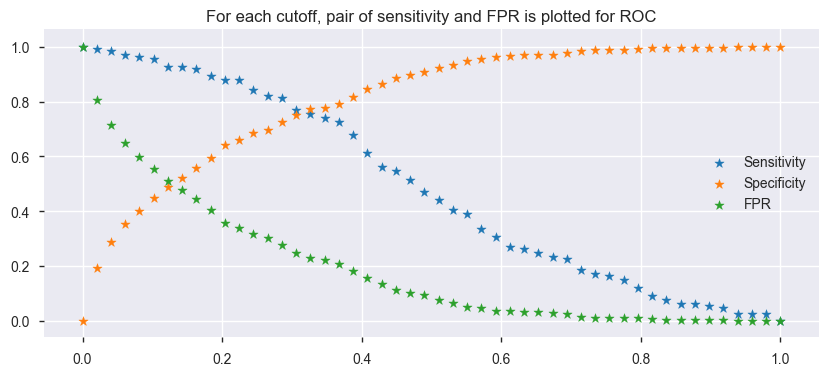

In [94]:
plt.subplots(figsize=(10,4))
plt.scatter(roc_like_df['cutoff'], roc_like_df['sensitivity'], marker='*', label='Sensitivity')
plt.scatter(roc_like_df['cutoff'], roc_like_df['specificity'], marker='*', label='Specificity')
plt.scatter(roc_like_df['cutoff'], 1-roc_like_df['specificity'], marker='*', label='FPR')
plt.title('For each cutoff, pair of sensitivity and FPR is plotted for ROC')
plt.legend()

In [42]:
## Finding ideal cut-off for checking if this remains same in OOS validation
roc_like_df['total'] = roc_like_df['sensitivity'] + roc_like_df['specificity']
roc_like_df[roc_like_df['total']==roc_like_df['total'].max()]

,cutoff,sensitivity,specificity,total
0,0.22449,0.880597,0.660112,1.540709


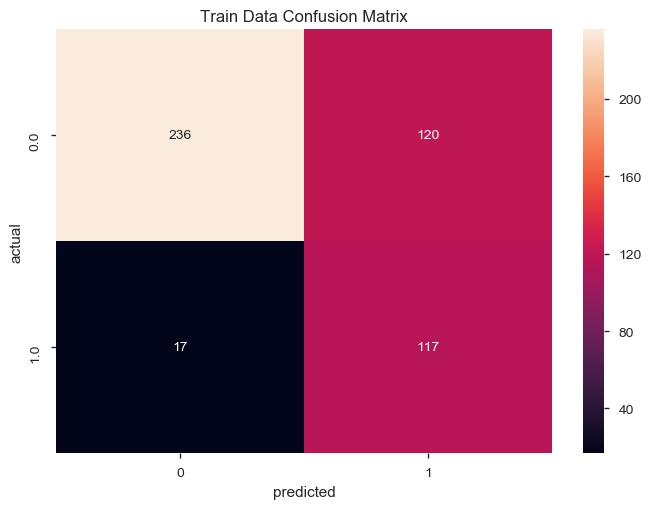

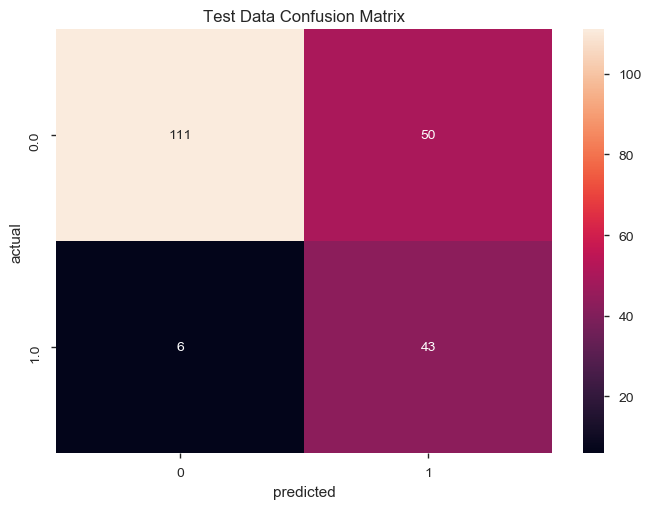

In [45]:
test_predict['predicted'] = test_predict['prob'].apply(lambda x: 1 if x > 0.23 else 0)
train_predict['predicted'] = train_predict['prob'].apply(lambda x: 1 if x > 0.23 else 0)
sns.heatmap(pd.crosstab(train_predict['actual'], train_predict['predicted']), annot=True, fmt='.0f')
plt.title('Train Data Confusion Matrix')
plt.show()
sns.heatmap(pd.crosstab(test_predict['actual'], test_predict['predicted']), annot=True, fmt='.0f')
plt.title('Test Data Confusion Matrix')
plt.show()
# (117+236)/(117+236+120+17)

In [46]:
print("The overall accuracy score for the Train Data is : ", metrics.accuracy_score(train_predict.actual, train_predict.predicted))
print("The overall accuracy score for the Test Data  is : ", metrics.accuracy_score(test_predict.actual, test_predict.predicted))

The overall accuracy score for the Train Data is :  0.7204081632653061
The overall accuracy score for the Test Data  is :  0.7333333333333333


In [36]:
train_predict['Deciles']=pd.qcut(train_predict['prob'],10, labels=False)
#test['Deciles']=pd.qcut(test['prob'],10, labels=False)
train_predict.head()

,actual,prob,predicted,Deciles
357,1.0,0.573708,1,8
649,0.0,0.500030,1,8
291,0.0,0.060040,0,2
420,1.0,0.574824,1,8
177,0.0,0.132731,0,3


In [37]:
df = train_predict[['Deciles','actual']].groupby(train_predict.Deciles).sum().sort_index(ascending=False)

In [39]:
df

,Deciles,actual
Deciles,,
9,441,36.0
8,392,28.0
7,343,26.0
6,294,15.0
5,245,13.0
4,196,6.0
3,147,5.0
2,98,3.0
1,49,2.0


In [78]:
train_predict[['Deciles','actual']].groupby(train_predict.Deciles).count().sort_index(ascending=False)

,Deciles,actual
Deciles,,
9,49,49
8,49,49
7,49,49
6,49,49
5,49,49
4,49,49
3,49,49
2,49,49
1,49,49


In [47]:
new_cust_prob = pd.DataFrame(result.predict(bankloans_new))


new_cust_prob.columns = ['prob1']

bankloans_new=pd.concat([bankloans_new, new_cust_prob.prob1], axis=1)

In [48]:
new_cust_prob.head(5)

,prob1
700,0.010895
701,0.115051
702,0.634835
703,0.104697
704,0.362317


In [56]:
bankloans_new.head()

,0,address,age,creddebt,debtinc,default,ed,employ,income,othdebt,prob,prob1
700,NaN,13.0,36.0,0.544128,10.9,NaN,1.0,16.0,32.0,2.943872,NaN,0.010895
701,NaN,27.0,50.0,1.316574,12.9,NaN,1.0,6.0,21.0,1.392426,NaN,0.115051
702,NaN,9.0,40.0,4.880700,17.0,NaN,1.0,9.0,33.0,0.729300,NaN,0.634835
703,NaN,7.0,31.0,0.046000,2.0,NaN,1.0,5.0,23.0,0.414000,NaN,0.104697
704,NaN,0.0,29.0,0.866736,7.8,NaN,1.0,4.0,24.0,1.005264,NaN,0.362317


In [49]:
bankloans_new['Bad'] = bankloans_new['prob1'].apply(lambda x: 1 if x > 0.23 else 0)

In [50]:
bankloans_new.head()

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default,prob1,Bad
700,36,1,16,13,32,10.9,0.544128,2.943872,NaN,0.010895,0
701,50,1,6,27,21,12.9,1.316574,1.392426,NaN,0.115051,0
702,40,1,9,9,33,17.0,4.880700,0.729300,NaN,0.634835,1
703,31,1,5,7,23,2.0,0.046000,0.414000,NaN,0.104697,0
704,29,1,4,0,24,7.8,0.866736,1.005264,NaN,0.362317,1
